Import Libraries

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from tensorflow.keras.optimizers import Adam

Upload files

In [ ]:
print("Upload train.zip and test.zip")
uploaded = files.upload()

Upload train.zip and test.zip


Saving test_zip.zip to test_zip.zip
Saving train_zip.zip to train_zip.zip


Unzip files

In [ ]:
with zipfile.ZipFile('/content/train_zip.zip', 'r') as zip_ref:
    zip_ref.extractall('content/train')

with zipfile.ZipFile('/content/test_zip.zip', 'r') as zip_ref:
    zip_ref.extractall('content/test')


Train and Test directories

In [ ]:
train_dir = 'content/train'
test_dir = 'content/test'

Extract data

In [ ]:
import csv
data={}
with open("/content/driver_imgs_list.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        key = row[1].lower()
        if key in data:
            data[key].append(row[2])
        else:
            data[key]=[row[2]]

List classes

In [ ]:
class_name = list(data.keys())
class_name

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

CNN model

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(100,100,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(8, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       6,554,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,586,408 (25.13 MB)

 Trainable params: 6,586,408 (25.13 MB)

 Non-trainable params: 0 (0.00 B)

extract features

In [ ]:
#name of the image converted to an array and one hot encoding of the expression this work done by the image data generator function
train_datagen = ImageDataGenerator(rescale=1.0/255)

# Update the train_dir path to the correct location of your training data
train_dir = 'content/train' # Update this path to the correct location

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100,100),
    class_mode='categorical',
    batch_size=128
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Update the test_dir path to the correct location of your test data
test_dir = 'content/test' # Update this path to the correct location

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    class_mode='categorical',
    batch_size=128
)

Found 1514 images belonging to 1 classes.
Found 352 images belonging to 1 classes.


EarlyStopping Function

In [ ]:
# it is used when epochs 5 and after 5 epochs model don't get update so the iteration gon waste , earlystopping function stop iterating
es = EarlyStopping(monitor = 'val_acc', patience = 2, min_delta = 0.01, mode='max')

In [ ]:
# Print the number of classes in the test set
print(f"Number of classes in test set: {test_generator.num_classes}")


Number of classes in test set: 1


Fit model

In [ ]:
model.fit(train_generator,
                    epochs = 10, verbose = 1,
                    validation_data = test_generator,
                    callbacks = [es])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7468 - loss: 0.5313 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - lo

Saving images.jpeg to images (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


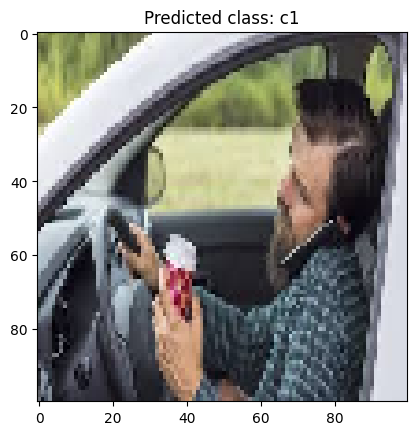

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load and preprocess the image
# Change target_size to (100, 100) to match the training input shape
img = image.load_img(image_path, target_size=(100, 100))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Assuming 'category_names' is defined and contains the class labels
# Display the image and predicted class
plt.imshow(img)
plt.title(f"Predicted class: {class_name[predicted_class]}")
plt.show()

Saving Sample1.jpg to Sample1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


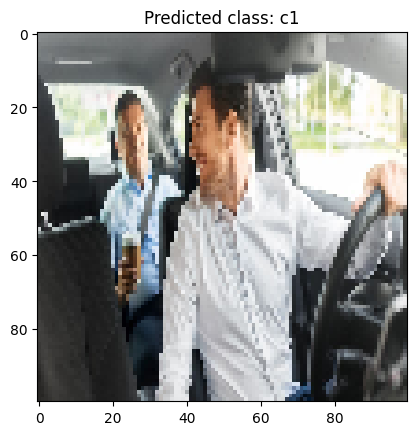

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load and preprocess the image
# Change target_size to (100, 100) to match the training input shape
img = image.load_img(image_path, target_size=(100, 100))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Assuming 'category_names' is defined and contains the class labels
# Display the image and predicted class
plt.imshow(img)
plt.title(f"Predicted class: {class_name[predicted_class]}")
plt.show()